In [13]:
%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install matplotlib yfinance scikit-learn scikit-optimize

  Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached yfinance-0.2.55-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached contourpy-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.2.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.me

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from river import metrics

# Importando as classes refatoradas
from utils.SeriesProcessor import SeriesProcessor
from utils.ModelTrainer import ModelTrainer
from utils.DriftEvaluator import DriftEvaluator
from utils.Visualizer import Visualizer
from utils.Optimizer import Optimizer
from utils.SaveCSV import SaveCSV
import pandas as pd

# Importando as classes existentes de otimização
from classes.otimizador.OtimizadorBayesiano import OtimizadorBayesiano

# 1. Importar os modelos e detectores de drift

In [3]:
# Importando detectores de drift
from classes.detectores.ADWINDetector import ADWINDetector
from classes.detectores.DDMDetector import DDMDetector
from classes.detectores.EDDMDetector import EDDMDetector
from classes.detectores.FHDDMDetector import FHDDMDetector
from classes.detectores.HDDM_ADetector import HDDM_ADetector
from classes.detectores.PageHinkleyDetector import PageHinkleyDetector
from classes.detectores.HDDM_WDetector import HDDM_WDetector
from classes.detectores.KSWINDetector import KSWINDetector

# Importando modelos offline
from classes.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from classes.modelosOffline.KneighborsRegressorModelo import KNeighborsRegressorModelo
from classes.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from classes.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from classes.modelosOffline.SVRModelo import SVRModelo
from classes.modelosOffline.RandomForestModelo import RandomForestModelo
from classes.modelosOffline.MLPRegressorModelo import MLPRegressorModelo

# Importando modelos online
from classes.modelosOnline.BayesianLinearRegressionModelo import BayesianLinearRegressionModelo
from classes.modelosOnline.HoeffdingTreeRegressorModelo import HoeffdingTreeRegressorModelo
from classes.modelosOnline.KNNRegressorOnlineModelo import KNNRegressorOnlineModelo
from classes.modelosOnline.LinearRegressionOnlineModelo import LinearRegressionOnlineModelo

# 2. Baixar e preparar os dados

In [4]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

In [5]:
# Definindo parâmetros para processamento
tamanho_batch = 50
lags = 5
serie_escolhida = series[-2]
print(f"Processando série: {serie_escolhida}")

# Baixando os dados da ação
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal.shape}")

# Gerando janelas temporais
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal, lags)
print(f"Shape dos dados de entrada: {X.shape}")
print(f"Shape dos dados de saída: {Y.shape}")

Processando série: ^BVSP
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1244, 1)
Shape dos dados de entrada: (1239, 5)
Shape dos dados de saída: (1239, 1)


# 3. Otimização de Hiperparâmetros

In [6]:
# Controle para executar ou pular otimização
executar_otimizacao = False #Mude para True quando quiser otimizar novamente

if executar_otimizacao:
    # Lista de modelos a otimizar (classes)
    modelos_offline = [
        LinearRegressionModelo,
        KNeighborsRegressorModelo,
        LassoRegressionModelo,
        #MLPRegressorModelo,  # Comentado por ser mais lento
        RandomForestModelo,
        RidgeRegressionModelo,
        SVRModelo
    ]

    modelos_online = [
        BayesianLinearRegressionModelo,
        HoeffdingTreeRegressorModelo,
        KNNRegressorOnlineModelo,
        LinearRegressionOnlineModelo
    ]

    # Inicializar o otimizador
    optimizer = OtimizadorBayesiano(n_iter=20, cv=3, random_state=42)

    # Otimizando todos os modelos
    modelos_otimizados, parametros_otimizados = Optimizer.otimizar_modelos_offline(
        X, Y, tamanho_batch, lags=lags, optimizer=optimizer,
        modelos_offline=modelos_offline,
    )

    # Salvar parâmetros otimizados para uso futuro
    import json
    with open('parametros_otimizados.json', 'w') as f:
        # Converter valores não serializáveis para strings
        params_serializaveis = {}
        for modelo, params in parametros_otimizados.items():
            params_serializaveis[modelo] = {k: str(v) for k, v in params.items()}
        json.dump(params_serializaveis, f, indent=4)

    print("Parâmetros otimizados salvos em 'parametros_otimizados.json'")
else:
    # Carregar parâmetros já otimizados
    import json
    import os
    import ast

    if os.path.exists('parametros_otimizados.json'):
        with open('parametros_otimizados.json', 'r') as f:
            params_carregados = json.load(f)

        # Convertendo strings de volta para valores adequados
        parametros_otimizados = {}
        for modelo, params in params_carregados.items():
            parametros_otimizados[modelo] = {}
            for k, v in params.items():
                # Tenta converter strings para valores Python
                try:
                    parametros_otimizados[modelo][k] = ast.literal_eval(v)
                except (ValueError, SyntaxError):
                    # Se falhar, mantém como string
                    parametros_otimizados[modelo][k] = v

        # Instanciando modelos com parâmetros otimizados
        modelos_otimizados = {}

        # Dicionário para mapear nomes de classes para referências reais de classes
        classes_modelos = {
            cls.__name__: cls for cls in
            [LinearRegressionModelo, KNeighborsRegressorModelo, LassoRegressionModelo,
             RandomForestModelo, RidgeRegressionModelo, SVRModelo,
             BayesianLinearRegressionModelo, HoeffdingTreeRegressorModelo,
             KNNRegressorOnlineModelo, LinearRegressionOnlineModelo]
        }

        for nome_modelo, params in parametros_otimizados.items():
            # Extrai o nome da classe do nome do modelo
            nome_classe = nome_modelo.split('_')[0]
            if nome_classe in classes_modelos:
                classe_modelo = classes_modelos[nome_classe]
                modelos_otimizados[nome_modelo] = classe_modelo(**params)
            else:
                print(f"Aviso: Classe {nome_classe} não encontrada!")

        print(f"Carregados {len(modelos_otimizados)} modelos com parâmetros otimizados")
    else:
        print("Arquivo de parâmetros não encontrado. Execute a otimização primeiro.")

Carregados 6 modelos com parâmetros otimizados


# 4. Executando Avaliação Prequential com Detecção de Drift

In [7]:
detector_escolhido = ADWINDetector

# Executando prequential com os modelos otimizados
resultados = {}
deteccoes_por_modelo = {}
dados_para_csv = []

for nome_modelo, modelo in modelos_otimizados.items():
    print(f"\nExecutando prequential para {nome_modelo}...")

    predicoes, deteccoes, mae, desvio_padrao = DriftEvaluator.prequential_batch(X, Y, tamanho_batch, modelo_classe=type(modelo), detector_classe=detector_escolhido)
    resultados[nome_modelo] = predicoes
    deteccoes_por_modelo[nome_modelo] = deteccoes
    num_deteccoes = len(deteccoes)

    print(f"Número de detecções para {nome_modelo}: {num_deteccoes}")

    dados_para_csv.append({
        'Modelo': nome_modelo,
        'Numero_Deteccoes': num_deteccoes,
        'MAE_Medio': mae.get(),
        'Std_Dev_Medio': desvio_padrao
    })

SaveCSV.salvar_resultados_csv(
    dados_para_csv,
    'resultados_prequential_deteccoes'
)


Executando prequential para LinearRegressionModelo...
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x752f0926f530>
MAE Modelo Batch: [0.09583477]
Desvio Padrão dos Erros: 0.07762219270475144
Número de detecções para LinearRegressionModelo: 0

Executando prequential para KNeighborsRegressorModelo...

Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.

Mudança detectada no índice 416, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 415 até 465.

Mudança detectada no índice 912, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 911 até 961.
Modelo utilizado: <classes.modelosOffline.KneighborsRegressorModelo.KNeighborsRegressorModelo object at 0x752f0b0ea7e0>
Detector utilizado: <classes.detectores.A

/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 416, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 415 até 465.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 912, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 911 até 961.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x752f08963bc0>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x752f08868e30>
MAE Modelo Batch: 0.41153996102527246
Desvio Padrão dos Erros: 0.4517777652357895
Número de detecções para RandomForestModelo: 3

Executando prequential para RidgeRegressionModelo...
Modelo utilizado: <classes.modelosOffline.RidgeRegressionModelo.RidgeRegressionModelo object at 0x752f08963bc0>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x752f090d1370>
MAE Modelo Batch: 0.10227826203890256
Desvio Padrão dos Erros: 0.07823300582399248
Número de detecções para RidgeRegressionModelo: 0

Executando prequential para SVRModelo...

Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.

Mudança detectada no índice 384, começando a coletar dados para retreino...
Janel

/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v


Nenhum drift detectado para LinearRegressionModelo.

Drift detectado para KNeighborsRegressorModelo nos índices: [176, 416, 912]

Drift detectado para LassoRegressionModelo nos índices: [176, 384, 720, 960]

Drift detectado para RandomForestModelo nos índices: [176, 416, 912]

Nenhum drift detectado para RidgeRegressionModelo.

Drift detectado para SVRModelo nos índices: [176, 384, 624, 928]


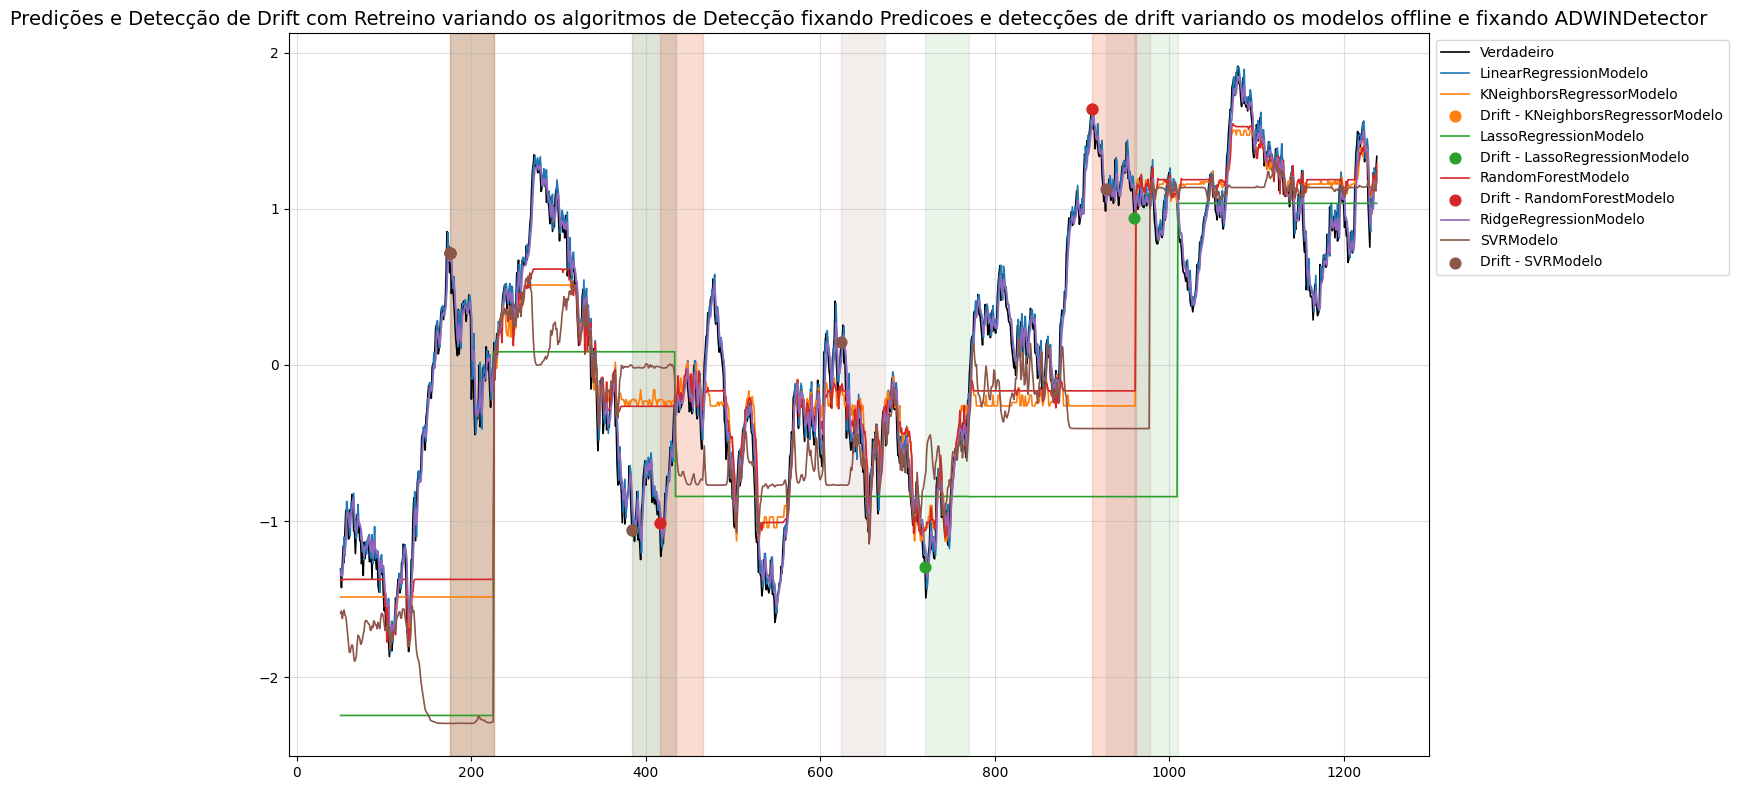

In [8]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  list(resultados.values()),
                  list(resultados.keys()),
                  deteccoes_por_modelo,
                  tamanho_batch,
                  detector_or_modelo="Predicoes e detecções de drift variando os modelos offline e fixando ADWINDetector",
                  )

# 5. Comparação de Detectores de Drift

In [9]:
modelo_escolhido = RandomForestModelo
print(f"Modelo selecionado para testes comparativos: {modelo_escolhido.__name__}")

# Lista de detectores a testar
detectores = [
    ADWINDetector,
    #DDMDetector,
    EDDMDetector,
    FHDDMDetector,
    HDDM_ADetector,
    PageHinkleyDetector,
    HDDM_WDetector,
    KSWINDetector
]

# Certifique-se que Y seja um array NumPy 1D, se necessário para prequential_batch
# y_true = np.array(Y).ravel() # Pode não ser necessário se prequential_batch lida com isso

resultados_detectores = {}
deteccoes_detectores = {}
dados_detectores_csv = []

for detector_classe in detectores:
    nome_detector = detector_classe.__name__
    print(f"\nTestando {nome_detector} com {modelo_escolhido.__name__}...")

    predicoes, deteccoes, mae_result, desvio_padrao_result = DriftEvaluator.prequential_batch(
        X, Y, tamanho_batch, modelo_classe=modelo_escolhido, detector_classe=detector_classe
    )

    resultados_detectores[nome_detector] = predicoes
    deteccoes_detectores[nome_detector] = deteccoes
    num_deteccoes = len(deteccoes)

    mae_valor = np.nan
    std_valor = np.nan
    try:
        temp_mae = mae_result.get() if hasattr(mae_result, 'get') else mae_result
        if isinstance(temp_mae, (list, np.ndarray)) and len(temp_mae) > 0:
            temp_mae = temp_mae[0]
        mae_valor = float(temp_mae)

        temp_std = desvio_padrao_result.get() if hasattr(desvio_padrao_result, 'get') else desvio_padrao_result
        if isinstance(temp_std, (list, np.ndarray)) and len(temp_std) > 0:
            temp_std = temp_std[0]
        std_valor = float(temp_std)

        print(f"  MAE Médio (retornado): {mae_valor:.4f}")
        print(f"  Desvio Padrão Médio dos Erros (retornado): {std_valor:.4f}")

    except (TypeError, IndexError, ValueError, AttributeError) as e:
        print(f"  Aviso: Não foi possível extrair valor numérico para MAE/StdDev retornado para {nome_detector}. Erro: {e}")

    print(f"  Número de detecções: {num_deteccoes}")

    dados_detectores_csv.append({
        'Detector': nome_detector,
        'MAE_Medio': mae_valor,
        'Std_Dev_Medio': std_valor,
        'Numero_Deteccoes': num_deteccoes
    })


df_resultados_detectores = pd.DataFrame(dados_detectores_csv)

nome_arquivo_csv_detectores = 'resultados_detectores_metricas.csv'
df_resultados_detectores.to_csv(nome_arquivo_csv_detectores, index=False, float_format='%.6f', na_rep='NaN')

print(f"\nResultados dos detectores salvos em {nome_arquivo_csv_detectores}")

print("\nResumo dos Resultados por Detector (Formatado):")

df_formatado_detectores = df_resultados_detectores.copy()

colunas_para_formatar = ['MAE_Medio', 'Std_Dev_Medio']
for col in colunas_para_formatar:
    if col in df_formatado_detectores.columns and pd.api.types.is_numeric_dtype(df_formatado_detectores[col]):
         df_formatado_detectores[col] = df_formatado_detectores[col].apply(lambda x: f'{x:.3f}' if pd.notna(x) else 'NaN')

print(df_formatado_detectores.to_string(index=False))

Modelo selecionado para testes comparativos: RandomForestModelo

Testando ADWINDetector com RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 416, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 415 até 465.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 912, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 911 até 961.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x752f088de150>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x752f03d3a630>
MAE Modelo Batch: 0.41022486586134277
Desvio Padrão dos Erros: 0.45167911514452275
  MAE Médio (retornado): 0.4102
  Desvio Padrão Médio dos Erros (retornado): 0.4517
  Número de detecções: 3

Testando EDDMDetector com RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x752f03d3a630>
Detector utilizado: <classes.detectores.EDDMDetector.EDDMDetector object at 0x752f03d3bb90>
MAE Modelo Batch: 1.5036602073302108
Desvio Padrão dos Erros: 0.8559277771760947
  MAE Médio (retornado): 1.5037
  Desvio Padrão Médio dos Erros (retornado): 0.8559
  Número de detecções: 0

Testando FHDDMDetector com RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 368, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 367 até 417.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 729, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 728 até 778.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1182, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1181 até 1231.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x752f03d0ba40>
Detector utilizado: <classes.detectores.FHDDMDetector.FHDDMDetector object at 0x752f03d3a720>
MAE Modelo Batch: 0.7262678689757583
Desvio Padrão dos Erros: 0.6230217084987791
  MAE Médio (retornado): 0.7263
  Desvio Padrão Médio dos Erros (retornado): 0.6230
  Número de detecções: 3

Testando HDDM_ADetector com RandomForestModelo...

Mudança detectada no índice 149, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 148 até 198.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 298, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 297 até 347.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 535, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 534 até 584.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 806, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 805 até 855.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 912, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 911 até 961.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1173, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1172 até 1222.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x752f03d02c90>
Detector utilizado: <classes.detectores.HDDM_ADetector.HDDM_ADetector object at 0x752f03d3b470>
MAE Modelo Batch: 0.37465720327849455
Desvio Padrão dos Erros: 0.38420612512625824
  MAE Médio (retornado): 0.3747
  Desvio Padrão Médio dos Erros (retornado): 0.3842
  Número de detecções: 6

Testando PageHinkleyDetector com RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 184, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 183 até 233.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 692, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 691 até 741.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 908, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 907 até 957.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x752f03d00920>
Detector utilizado: <classes.detectores.PageHinkleyDetector.PageHinkleyDetector object at 0x752f03d02480>
MAE Modelo Batch: 0.5689715430554702
Desvio Padrão dos Erros: 0.5370961175763721
  MAE Médio (retornado): 0.5690
  Desvio Padrão Médio dos Erros (retornado): 0.5371
  Número de detecções: 3

Testando HDDM_WDetector com RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 153, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 152 até 202.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 385, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 384 até 434.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 805, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 804 até 854.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 919, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 918 até 968.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x752f03be3e00>
Detector utilizado: <classes.detectores.HDDM_WDetector.HDDM_WDetector object at 0x752f03bfaf90>
MAE Modelo Batch: 0.3737730019762176
Desvio Padrão dos Erros: 0.3806357328338232
  MAE Médio (retornado): 0.3738
  Desvio Padrão Médio dos Erros (retornado): 0.3806
  Número de detecções: 4

Testando KSWINDetector com RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 148, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 147 até 197.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 296, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 295 até 345.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 448, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 447 até 497.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 596, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 595 até 645.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 744, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 743 até 793.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 892, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 891 até 941.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1040, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1039 até 1089.


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1188, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1187 até 1237.
Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x752f03be2ff0>
Detector utilizado: <classes.detectores.KSWINDetector.KSWINDetector object at 0x752f03bf35c0>
MAE Modelo Batch: 0.3498606838623393
Desvio Padrão dos Erros: 0.38869870596472267
  MAE Médio (retornado): 0.3499
  Desvio Padrão Médio dos Erros (retornado): 0.3887
  Número de detecções: 8

Resultados dos detectores salvos em resultados_detectores_metricas.csv

Resumo dos Resultados por Detector (Formatado):
           Detector MAE_Medio Std_Dev_Medio  Numero_Deteccoes
      ADWINDetector     0.410         0.452                 3
       EDDMDetector     1.504         0.856                 0
      FHDDMDetector     0.726         0.623                 3
     HDDM_ADetector     0.375         0.384                 6
PageHinkleyDetector  

/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Drift detectado para ADWINDetector nos índices: [176, 416, 912]

Nenhum drift detectado para EDDMDetector.

Drift detectado para FHDDMDetector nos índices: [368, 729, 1182]

Drift detectado para HDDM_ADetector nos índices: [149, 298, 535, 806, 912, 1173]

Drift detectado para PageHinkleyDetector nos índices: [184, 692, 908]

Drift detectado para HDDM_WDetector nos índices: [153, 385, 805, 919]

Drift detectado para KSWINDetector nos índices: [148, 296, 448, 596, 744, 892, 1040, 1188]


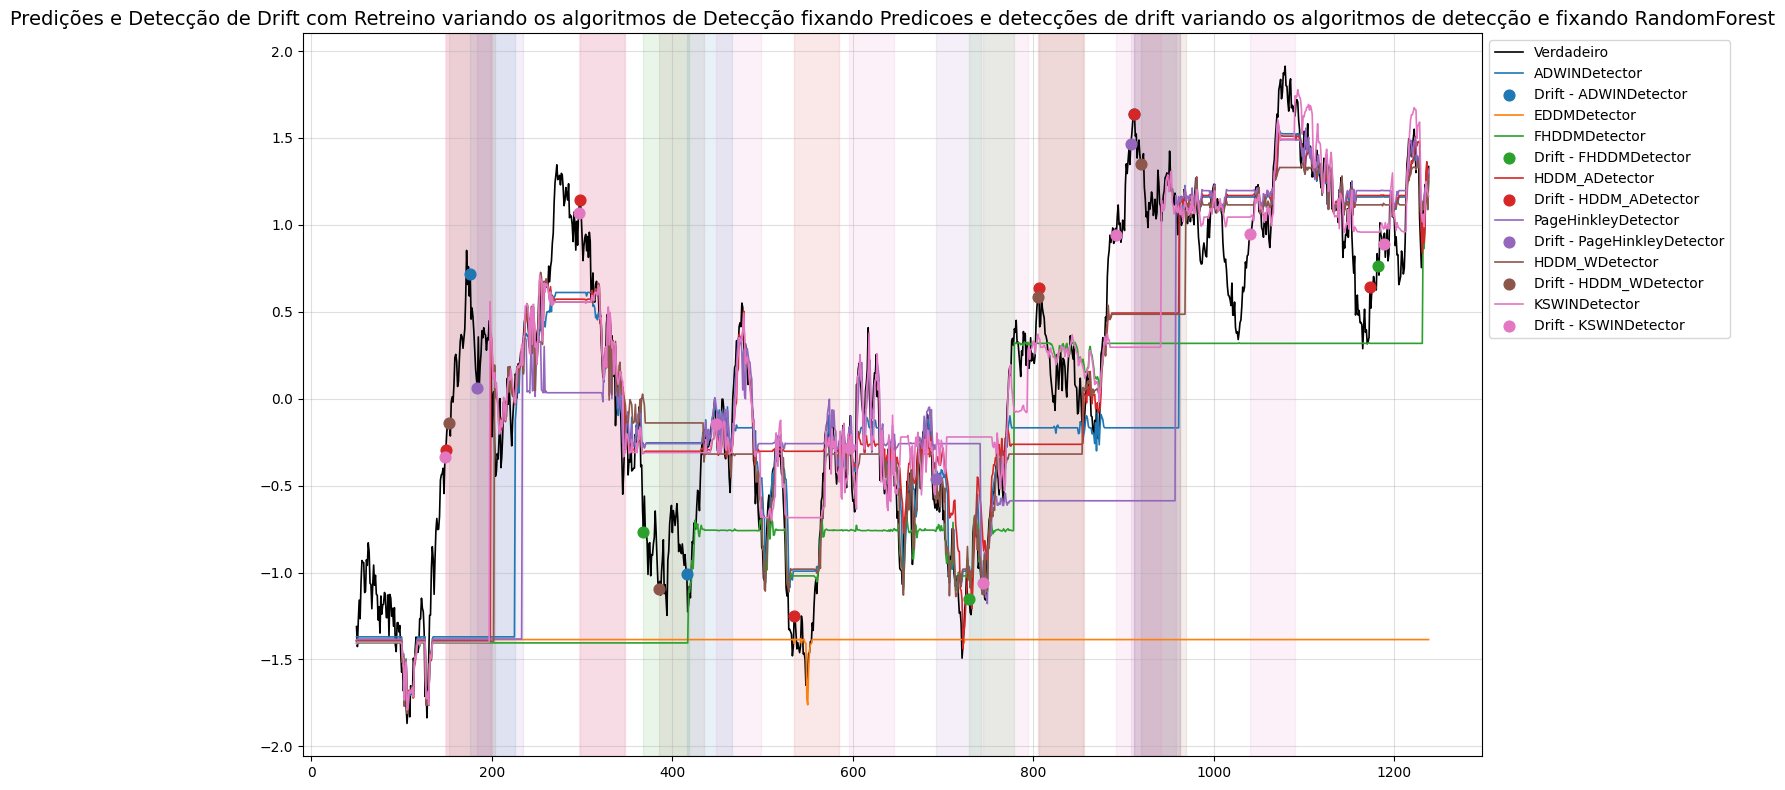

In [10]:
Visualizer.plotar_resultados_multi(Y,
                  list(resultados_detectores.values()),
                  list(resultados_detectores.keys()),
                  deteccoes_detectores,
                  tamanho_batch,
                  detector_or_modelo="Predicoes e detecções de drift variando os algoritmos de detecção e fixando RandomForest",
                  )

# 6. Resultado dos Modelos Online

In [11]:
resultados = {}
deteccoes_por_modelo = {}
dados_para_csv = []

modelos_online = [
        BayesianLinearRegressionModelo,
        HoeffdingTreeRegressorModelo,
        KNNRegressorOnlineModelo,
        LinearRegressionOnlineModelo
    ]

for modelo_classe in modelos_online:
    print(f"\nExecutando prequential para {modelo_classe.__name__}...")

    predicoes, mae, desvio_padrao = DriftEvaluator.prequential_passivo(X, Y, tamanho_batch, modelo_classe)
    resultados[modelo_classe.__name__] = predicoes

    dados_para_csv.append({
        'Modelo': modelo_classe.__name__,
        'MAE_Medio': mae.get(),
        'Std_Dev_Medio': desvio_padrao
    })

SaveCSV.salvar_resultados_csv(
    dados_para_csv=dados_para_csv,
    nome_arquivo_csv='resultados_prequential_passivo2'
)


Executando prequential para BayesianLinearRegressionModelo...
Modelo utilizado: <classes.modelosOnline.BayesianLinearRegressionModelo.BayesianLinearRegressionModelo object at 0x752f03bf9730>
MAE Modelo Online: 0.09184947780116395

Executando prequential para HoeffdingTreeRegressorModelo...
Modelo utilizado: <classes.modelosOnline.HoeffdingTreeRegressorModelo.HoeffdingTreeRegressorModelo object at 0x752f03c88b00>
MAE Modelo Online: 0.11577269076046716

Executando prequential para KNNRegressorOnlineModelo...
Modelo utilizado: <classes.modelosOnline.KNNRegressorOnlineModelo.KNNRegressorOnlineModelo object at 0x752f74108110>
MAE Modelo Online: 0.12072127700440517

Executando prequential para LinearRegressionOnlineModelo...
Modelo utilizado: <classes.modelosOnline.LinearRegressionOnlineModelo.LinearRegressionOnlineModelo object at 0x752f74108110>
MAE Modelo Online: 0.11577269076046716

Resultados salvos em resultados_prequential_passivo2.csv

Resumo dos Resultados:
                        


Nenhum drift detectado para BayesianLinearRegressionModelo.

Nenhum drift detectado para HoeffdingTreeRegressorModelo.

Nenhum drift detectado para KNNRegressorOnlineModelo.

Nenhum drift detectado para LinearRegressionOnlineModelo.


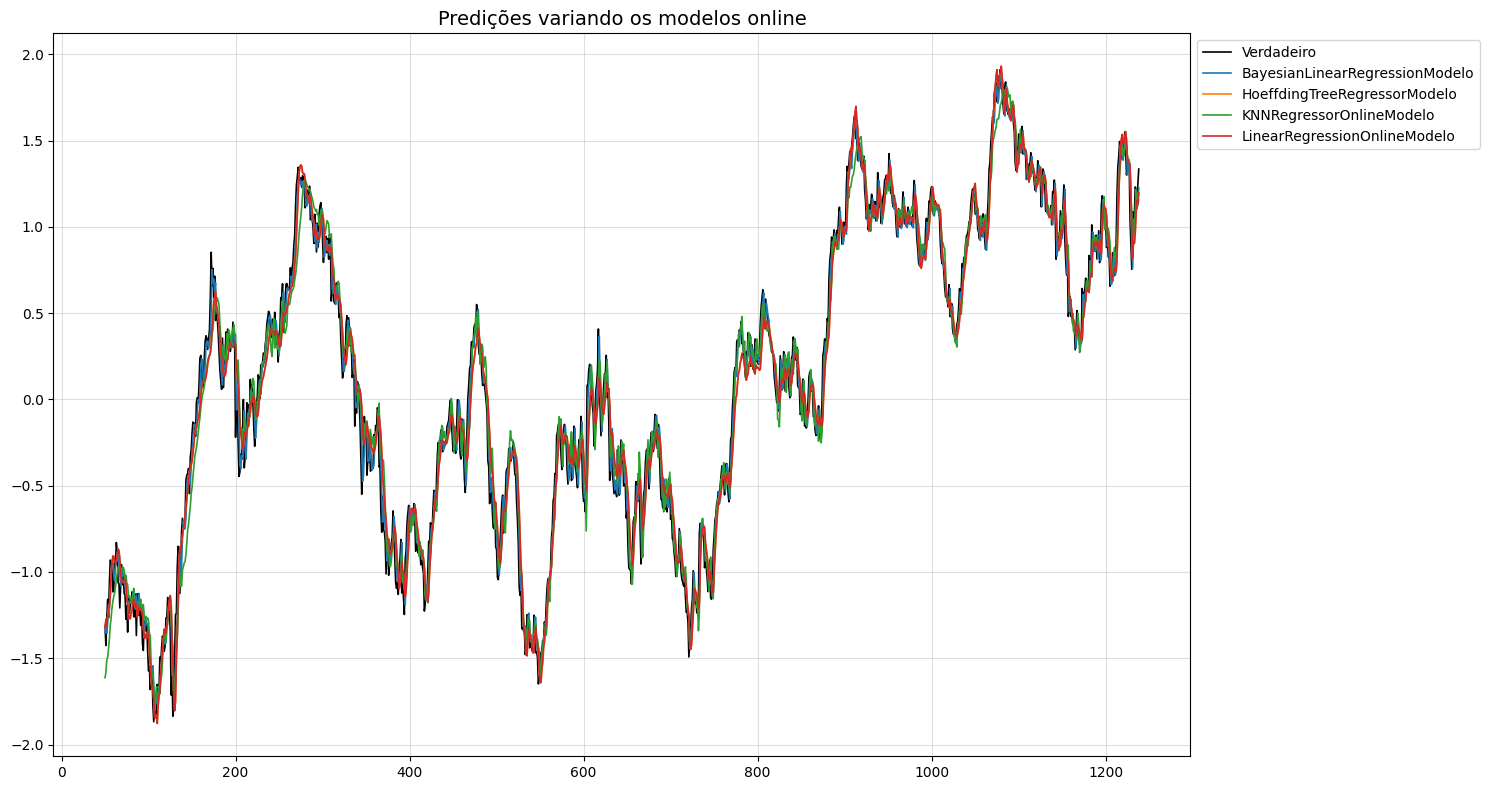

In [12]:
Visualizer.plotar_resultados(
    Y,
    list(resultados.values()),
    list(resultados.keys()),
    deteccoes_por_modelo={},
    tamanho_batch=tamanho_batch,
    titulo_plot="Predições variando os modelos online",
)